<a href="https://colab.research.google.com/github/fathinmusthafa/KlasifikasiCitraFluoresensi/blob/main/Diskriminasi-Citra-Flouresensi-KulitBabidanSapi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive/')

Mounted at /content/drive/


Menyiapkan Direktori

In [ ]:
base_dir = '/content/drive/My Drive/Diskriminasi1/'
!ls "/content/drive/My Drive/Diskriminasi1/"

bahan  latih  model  validasi


In [ ]:
#menentukan direktori
bahan_dir = os.path.join(base_dir, 'bahan')
train_dir = os.path.join(base_dir, 'latih')
validation_dir = os.path.join(base_dir, 'validasi')


In [ ]:
#menentukan direktori isi bahan
babi_dir = os.path.join(bahan_dir, 'babi/')
sapi_dir = os.path.join(bahan_dir, 'sapi/')

print("Jumlah data train tiap kelas")
print("Jumlah citra kulit babi  :", len(os.listdir(babi_dir)))
print("Jumlah citra kulit sapi  :", len(os.listdir(sapi_dir)))

Jumlah data train tiap kelas
Jumlah citra kulit babi  : 100
Jumlah citra kulit sapi  : 100


In [ ]:
#Direktori isi latih/training
train_babi = os.path.join(train_dir, 'babi/')
train_sapi = os.path.join(train_dir, 'sapi/')

#Direktori isi validasi
validation_babi = os.path.join(validation_dir, 'babi/')
validation_sapi = os.path.join(validation_dir, 'sapi/')


Menyiapkan Dataset

In [ ]:
import random
from shutil import copyfile


def train_val_split(source, train, val, train_ratio):
  total_size = len(os.listdir(source))
  train_size = int(train_ratio * total_size)
  val_size = total_size - train_size

  randomized = random.sample(os.listdir(source), total_size)
  train_files = randomized[0:train_size]
  val_files = randomized[train_size:total_size]

  for i in train_files:
    i_file = source + i
    destination = train + i
    copyfile(i_file, destination)

  for i in val_files:
    i_file = source + i
    destination = val + i
    copyfile(i_file, destination)

#jumlah pembagian data training dan validasi
train_ratio = 0.8

#pembagian training dan validasi
#training
source_00 = babi_dir
train_00 = train_babi
val_00 = validation_babi
train_val_split(source_00, train_00, val_00, train_ratio)

#validasi
source_01 = sapi_dir
train_01 = train_sapi
val_01 = validation_sapi
train_val_split(source_01, train_01, val_01, train_ratio)

In [ ]:
print('Jumlah Semua Babi  :', len(os.listdir(babi_dir)))
print('Jumlah Train Babi  :', len(os.listdir(train_babi)))
print('Jumlah Val Babi    :', len(os.listdir(validation_babi)))

Jumlah Semua Babi  : 100
Jumlah Train Babi  : 80
Jumlah Val Babi    : 20


Pre Processing


In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
                rescale = 1./255,
                rotation_range = 30,
                horizontal_flip = True,
                shear_range = 0.3,
                fill_mode = 'nearest',
                width_shift_range = 0.2,
                height_shift_range = 0.2,
                zoom_range = 0.1
)

val_datagen = ImageDataGenerator(
                rescale = 1./255,
                rotation_range = 30,
                horizontal_flip = True,
                shear_range = 0.3,
                fill_mode = 'nearest',
                width_shift_range = 0.2,
                height_shift_range = 0.2,
                zoom_range = 0.1
)

Target

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 10,
    class_mode = 'categorical'
)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 10,
    class_mode = 'categorical'
)

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if(logs.get('accuracy') > 0.99):
      print('\nAkurasi mencapai 99%')
      self.model.stop_training = True

callbacks = myCallback()

Model CNN

In [ ]:
model = tf.keras.models.Sequential([
          tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', input_shape = (150, 150,3)),
          tf.keras.layers.MaxPooling2D(2,2),
          tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
          tf.keras.layers.MaxPooling2D(2,2),
          tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
          tf.keras.layers.MaxPooling2D(2,2),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(200, activation = 'relu'),
          tf.keras.layers.Dropout(0.3,seed=112),
          tf.keras.layers.Dense(500, activation = 'relu'),
          tf.keras.layers.Dropout(0.5,seed=112),
          tf.keras.layers.Dense(2, activation = 'sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [ ]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'Adam',
              metrics = ['accuracy'])

In [ ]:
import keras as tf
# define the checkpoint
checkpoint_filepath = "/content/drive/My Drive/Diskriminasi1/model/kulitbabi-kulitsapi-{epoch:02d}-{accuracy:.4f}-{val_accuracy:.4f}.h5"
model_checkpoint_callback = tf.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only = False,
    monitor = 'accuracy',
    mode = 'max',
    save_best_only = True)

history = model.fit(
            train_generator,
            steps_per_epoch = 8,
            epochs = 100,
            validation_data = val_generator,
            validation_steps = 1,
            verbose = 1,
            callbacks = [model_checkpoint_callback])

Epoch 1/100
8/8 [==============================] - 12s 275ms/step - loss: 0.8194 - accuracy: 0.4625 - val_loss: 0.7105 - val_accuracy: 0.4000
Epoch 2/100
8/8 [==============================] - 2s 253ms/step - loss: 0.6906 - accuracy: 0.5625 - val_loss: 0.6807 - val_accuracy: 0.6000
Epoch 3/100
8/8 [==============================] - 2s 234ms/step - loss: 0.7082 - accuracy: 0.4875 - val_loss: 0.6823 - val_accuracy: 0.6000
Epoch 4/100
8/8 [==============================] - 2s 219ms/step - loss: 0.6905 - accuracy: 0.5250 - val_loss: 0.7129 - val_accuracy: 0.3000
Epoch 5/100
8/8 [==============================] - 2s 224ms/step - loss: 0.6852 - accuracy: 0.5250 - val_loss: 0.7525 - val_accuracy: 0.3000
Epoch 6/100
8/8 [==============================] - 2s 272ms/step - loss: 0.6832 - accuracy: 0.5500 - val_loss: 0.7640 - val_accuracy: 0.3000
Epoch 7/100
8/8 [==============================] - 2s 227ms/step - loss: 0.6909 - accuracy: 0.5375 - val_loss: 0.6797 - val_accuracy: 0.6000
Epoch 8/100


Tingkat akurasi dan loss model

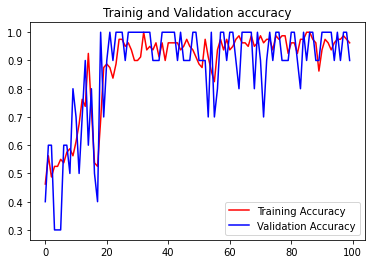

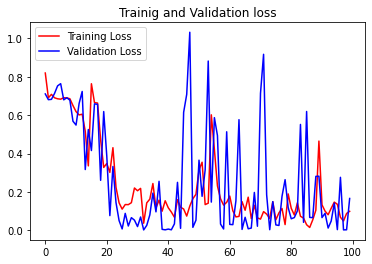

In [ ]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Trainig and Validation accuracy')
plt.legend(loc = 'best')
plt.show()

plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Trainig and Validation loss')
plt.legend(loc = 'best')
plt.show()

In [ ]:
train_generator.class_indices

{'babi': 0, 'sapi': 1}

In [ ]:
true_label = [0] * 30
for i in range(2, 11):
  true_label[i]=1

**Pengujian**

load model

In [ ]:
from tensorflow.keras.models import load_model

DIR = "/content/drive/My Drive/Diskriminasi1/model/"
# load model
model = load_model(DIR+"kulitbabi-kulitsapi-33-1.0000-1.0000.h5")

prediksi

Saving citra uji babi 01.png to citra uji babi 01 (2).png
citra uji babi 01.png
This image belongs to class Kulit Babi


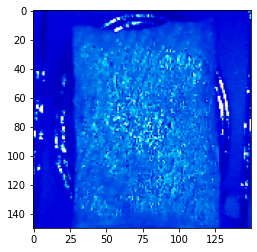

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
from termcolor import colored

uploaded = files.upload()

for fn in uploaded.keys():

  path = fn
  img = image.load_img(path, target_size=(150, 150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  if classes[0][0]==1:
    print(colored('This image belongs to class Kulit Babi', attrs=['bold']))
  elif classes[0][1]==1:
    print(colored('This image belongs to class Kulit Sapi', attrs=['bold'])) 
  else:
    print('Tidak Diketahui') 

In [ ]:
base_dir = '/content/drive/My Drive/Diskriminasi1/'
test_dir = os.path.join(base_dir, 'test')

#Direktori isi test
test_babi = os.path.join(test_dir, 'babi/')
test_sapi = os.path.join(test_dir, 'sapi/')

In [ ]:
import numpy
from keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)
test_data_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=10,
        class_mode='binary')
test_steps_per_epoch = numpy.math.ceil(test_data_generator.samples / test_data_generator.batch_size)


Found 20 images belonging to 2 classes.


In [ ]:
predictions = model.predict(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = numpy.round(predictions, 0)

In [ ]:
from keras import metrics
true_classes = test_data_generator.classes
class_labels = ['babi','sapi']
#for i in range(2):
#class_labels.append("kelas_"+str(i))
#print(len(class_labels))

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(true_classes, predicted_classes))

report = classification_report(true_classes, predicted_classes, target_names=class_labels, digits=4)
print(report)

ValueError: ignored